In [3]:
!pip install imblearn
!pip install xgboost
!pip install catboost
!pip install lightgbm
!pip install optuna
!pip install nltk
!pip install gensim


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

import pandas as pd

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import optuna

from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import make_scorer
from imblearn.ensemble import BalancedBaggingClassifier
import joblib
from sklearn.metrics import matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from src.functions.vectorize_functions import vectorize_tfidf, vectorize_glove, vectorize_w2v

#### Evaluations-Funktionen

In [49]:
def simple_evaluation(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [50]:
evaluation = pd.DataFrame(
    columns=["model", "train_acc", "train_prec", "train_rec", "train_f1", "train_mcc", 
             "test_acc", "test_prec","test_rec", "test_f1", "test_mcc"])


def add_to_eval_df(model, model_name, x_data_train, y_data_train, x_data_test, y_data_test):
    train_pred = model.predict(x_data_train)
    train_acc = accuracy_score(y_data_train, train_pred)
    train_precision = precision_score(y_data_train, train_pred)
    train_recall = recall_score(y_data_train, train_pred)
    train_f1 = f1_score(y_data_train, train_pred)
    train_mcc = matthews_corrcoef(y_data_train, train_pred)

    test_pred = model.predict(x_data_test)
    test_acc = accuracy_score(y_data_test, test_pred)
    test_precision = precision_score(y_data_test, test_pred)
    test_recall = recall_score(y_data_test, test_pred)
    test_f1 = f1_score(y_data_test, test_pred)
    test_mcc = matthews_corrcoef(y_data_test, test_pred)

    evaluation.loc[len(evaluation.index)] = [model_name, 
                                             train_acc, train_precision, train_recall,train_f1,train_mcc,
                                             test_acc, test_precision, test_recall, test_f1, test_mcc]

In [140]:
evaluation_tuning = pd.DataFrame(
    columns=["model", "tuning", "scorer", "best_params",
             "train_acc", "train_prec", "train_rec", "train_f1", "train_mcc",
             "test_acc", "test_prec", "test_rec", "test_f1", "test_mcc",
             "clf_rep_train", "clf_rep_test"])


def add_to_tuning_eval_df(model, model_name, tuning, scorer, best_params, x_data_train, y_data_train, x_data_test,
                          y_data_test):
    train_pred = model.predict(x_data_train)
    train_acc = accuracy_score(y_data_train, train_pred)
    train_precision = precision_score(y_data_train, train_pred)
    train_recall = recall_score(y_data_train, train_pred)
    train_f1 = f1_score(y_data_train, train_pred)
    train_mcc = matthews_corrcoef(y_data_train, train_pred)
    clf_rep_train = classification_report(y_data_train, train_pred)

    test_pred = model.predict(x_data_test)
    test_acc = accuracy_score(y_data_test, test_pred)
    test_precision = precision_score(y_data_test, test_pred)
    test_recall = recall_score(y_data_test, test_pred)
    test_f1 = f1_score(y_data_test, test_pred)
    test_mcc = matthews_corrcoef(y_data_test, test_pred)
    clf_rep_test = classification_report(y_data_test, test_pred)

    evaluation_tuning.loc[len(evaluation_tuning.index)] = [model_name, tuning, scorer, best_params,
                                                           train_acc, train_precision, train_recall, train_f1,train_mcc,
                                                           test_acc, test_precision, test_recall, test_f1,test_mcc,
                                                           clf_rep_train, clf_rep_test]

In [279]:
final_evaluation_tuning = pd.DataFrame(
    columns=["model", "tuning", "scorer", "thresh",
             "train_acc", "train_prec", "train_rec", "train_f1", "train_mcc",
             "val_acc", "val_prec", "val_rec", "val_f1", "val_mcc",
             "test_acc", "test_prec", "test_rec", "test_f1","test_mcc",
             "clf_rep_train", "clf_rep_val", "clf_rep_test", "best_params"])


def add_to_final_eval_df(model, model_name, tuning, scorer, best_params, x_data_train, y_data_train, x_data_val,
                         y_data_val, x_data_test, y_data_test, thresh):
    
    train_proba = model.predict_proba(x_data_train)
    train_pred = [1 if train_proba[i][1]> thresh else 0 for i in range(len(train_proba))]  
    
    train_acc = accuracy_score(y_data_train, train_pred)
    train_precision = precision_score(y_data_train, train_pred)
    train_recall = recall_score(y_data_train, train_pred)
    train_f1 = f1_score(y_data_train, train_pred)
    train_mcc = matthews_corrcoef(y_data_train, train_pred)
    clf_rep_train = classification_report(y_data_train, train_pred)
    
    val_proba = model.predict_proba(x_data_val)
    val_pred = [1 if val_proba[i][1]> thresh else 0 for i in range(len(val_proba))]
    
    val_acc = accuracy_score(y_data_val, val_pred)
    val_precision = precision_score(y_data_val, val_pred)
    val_recall = recall_score(y_data_val, val_pred)
    val_f1 = f1_score(y_data_val, val_pred)
    val_mcc = matthews_corrcoef(y_data_val, val_pred)
    clf_rep_val = classification_report(y_data_val, val_pred)
    
    test_proba = model.predict_proba(x_data_test)
    test_pred = [1 if test_proba[i][1]> thresh else 0 for i in range(len(test_proba))]

    test_acc = accuracy_score(y_data_test, test_pred)
    test_precision = precision_score(y_data_test, test_pred)
    test_recall = recall_score(y_data_test, test_pred)
    test_f1 = f1_score(y_data_test, test_pred)
    test_mcc = matthews_corrcoef(y_data_test, test_pred)
    clf_rep_test = classification_report(y_data_test, test_pred)

    final_evaluation_tuning.loc[len(final_evaluation_tuning.index)] = [model_name, tuning, scorer, thresh,
                                                                 train_acc, train_precision, train_recall, train_f1,train_mcc,
                                                                 val_acc, val_precision, val_recall, val_f1,val_mcc,
                                                                 test_acc, test_precision, test_recall, test_f1,test_mcc,
                                                                 clf_rep_train, clf_rep_val, clf_rep_test, best_params]

#### Daten einlesen

In [4]:
df_train = pd.read_csv("../../../data/mixed_dataset/train_cleaned.csv", index_col=0)
# df_train = df_train[df_train.tweet.notna() & df_train.tweet_cleaned.notna()]
df_train = df_train[df_train.tweet_cleaned.notna()]
df_train.head()

,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
140232,0,"Nicki's ""that's not good"" pout bought to you b...","nickis "" good pout buy botox trade mark mkr",0,['#mkr'],__trade_mark__
6083,0,@user @user @user @user @user @user greater g...,great game ever fun possible,6,"['#fun', '#possible']",NaN
62913,0,I love that you enjoy being trans.,love enjoy tran,0,[],NaN
13525,0,yes good shapely eurotrash manbooty,yes good eurotrash,0,[],NaN
6318,0,i can't wait for euro 2016 to sta on friday #e...,wait euro sta friday euro,0,['#euro2016'],NaN


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81904 entries, 140232 to 145236
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          81904 non-null  int64 
 1   tweet          81904 non-null  object
 2   tweet_cleaned  81904 non-null  object
 3   user_handle    81904 non-null  int64 
 4   hashtags       81904 non-null  object
 5   emojis         7605 non-null   object
dtypes: int64(2), object(4)
memory usage: 4.4+ MB


#### Vergleich von Vektorisierungsarten

##### TF-IDF

In [5]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf, tfidf_vectorizer = vectorize_tfidf(df=df_train,
                                                                                 text_column="tweet_cleaned",
                                                                                 label_column="label")

##### Word2Vec

In [ ]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v, vectorizer_w2v = vectorize_w2v(df=df_train,
                                                                 text_column="tweet_cleaned",
                                                                 label_column="label")

##### GloVe

In [ ]:
X_train_gl, X_test_gl, y_train_gl, y_test_gl, vectorizer_gl = vectorize_glove(df=df_train,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

##### Vergleich der Vektorisierungsarten mit Baseline-Modell (RandomForest)

In [ ]:
rf_base_tf = RandomForestClassifier(n_jobs=-1)
rf_base_tf.fit(X_train_tf, y_train_tf)
y_pred_base_tf = rf_base_tf.predict(X_test_tf)

In [ ]:
simple_evaluation(y_test_tf, y_pred_base_tf)

In [ ]:
rf_base_w2v = RandomForestClassifier(n_jobs=-1)
rf_base_w2v.fit(X_train_w2v, y_train_w2v)
y_pred_base_w2v = rf_base_w2v.predict(X_test_w2v)

In [ ]:
simple_evaluation(y_test_w2v, y_pred_base_w2v)

In [ ]:
rf_base_gl = RandomForestClassifier(n_jobs=-1)
rf_base_gl.fit(X_train_gl, y_train_gl)
y_pred_base_gl = rf_base_gl.predict(X_test_gl)

In [ ]:
simple_evaluation(y_test_gl, y_pred_base_gl)

###### Entscheidung: TF-IDF
==> W2V und GLOVE sind beide schlechter als TF-IDF bei F1 und Recall des Targets

W2V und GLOVE werden nicht mehr betrachtet

In [6]:
X_train, X_test, y_train, y_test = X_train_tf, X_test_tf, y_train_tf, y_test_tf

In [7]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (57332, 13198)
y_train (57332,)
X_test (24572, 13198)
y_test (24572,)


#### Vergleich von Modellen ohne Hyperparamtertuning

##### RandomForestClassifier

In [53]:
rf_base = RandomForestClassifier(n_jobs=-1)
rf_base.fit(X_train, y_train)

add_to_eval_df(model=rf_base, model_name="RandomForestClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

##### BalancedRandomForestClassifier / BalancedBaggingClassifier (imblearn)

In [54]:
brf_base = BalancedRandomForestClassifier(n_jobs=-1)
brf_base.fit(X_train, y_train)

add_to_eval_df(model=brf_base, model_name="BalancedRandomForestClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

In [55]:
brf_base_pred = brf_base.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_base_pred)

Accuracy: 0.8018641377345436

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.83      0.87     20125
           1       0.47      0.65      0.54      4444

    accuracy                           0.80     24569
   macro avg       0.69      0.74      0.71     24569
weighted avg       0.83      0.80      0.81     24569



In [56]:
brf_img_base = BalancedBaggingClassifier(n_jobs=-1)
brf_img_base.fit(X_train, y_train)

add_to_eval_df(model=brf_img_base, model_name="BalancedBaggingClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

##### XGBClassifier

In [57]:
xgb_base = XGBClassifier(n_jobs=-1)
xgb_base.fit(X_train, y_train)

add_to_eval_df(model=xgb_base, model_name="XGBClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

##### CatBoostClassifier

In [ ]:
cat_base = CatBoostClassifier()
cat_base.fit(X_train, y_train)

add_to_eval_df(model=cat_base, model_name="CatBoostClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

##### LGBMClassifier

In [59]:
lgb_base = LGBMClassifier(n_jobs=-1)
lgb_base.fit(X_train, y_train)

add_to_eval_df(model=lgb_base, model_name="LGBMClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

[LightGBM] [Info] Number of positive: 10299, number of negative: 47028
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.250621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129768
[LightGBM] [Info] Number of data points in the train set: 57327, number of used features: 3276
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.179654 -> initscore=-1.518696
[LightGBM] [Info] Start training from score -1.518696


##### StackingClassifier

In [60]:
base_models_stack = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', LinearSVC(random_state=42))
]
stack_base = StackingClassifier(estimators=base_models_stack, n_jobs=-1)
stack_base.fit(X_train, y_train)

add_to_eval_df(model=stack_base, model_name="StackingClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

##### VotingClassifier

In [61]:
base_models_vote = [
    ('lr', LogisticRegression(random_state=42)), ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('svc', LinearSVC(random_state=42))
]

vote_base = VotingClassifier(estimators=base_models_vote, voting='hard', n_jobs=-1)
vote_base.fit(X_train, y_train)

add_to_eval_df(model=vote_base, model_name="VotingClassifier", x_data_train=X_train, y_data_train=y_train,
               x_data_test=X_test, y_data_test=y_test)

##### Vergleich der Modelle ohne Tuning

In [62]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,train_acc,train_prec,train_rec,train_f1,train_mcc,test_acc,test_prec,test_rec,test_f1,test_mcc
1,BalancedRandomForestClassifier,0.933173,0.728907,0.999903,0.843165,0.818201,0.801864,0.465916,0.652115,0.543511,0.431146
2,BalancedBaggingClassifier,0.896070,0.640295,0.961841,0.768801,0.729502,0.792381,0.448760,0.647390,0.530078,0.413527
6,StackingClassifier,0.992011,0.988000,0.967278,0.977529,0.972752,0.854329,0.690781,0.352385,0.466696,0.422351
4,CatBoostClassifier,0.871928,0.831725,0.359938,0.502440,0.493169,0.853433,0.726248,0.304455,0.429047,0.405844
5,LGBMClassifier,0.867602,0.804040,0.347801,0.485563,0.472115,0.850584,0.713654,0.290504,0.412922,0.390220
3,XGBClassifier,0.873393,0.846434,0.360715,0.505855,0.500110,0.850584,0.714127,0.290054,0.412546,0.390101
7,VotingClassifier,0.899576,0.868908,0.519371,0.650137,0.622731,0.848508,0.694504,0.290054,0.409206,0.381444
0,RandomForestClassifier,0.999599,0.999417,0.998349,0.998883,0.998638,0.848427,0.725282,0.260801,0.383648,0.373037


###### Zwischenenergebnis

- deutliche Unterschiede BRF <-> alle anderen ohne Over/Undersampling vorhanden => erneuter Trainingslauf mit SMOTE

#### Vergleich von Modellen ohne Hyperparamtertuning - SMOTE

In [8]:
resampler = SMOTE()
X_smote, y_smote = resampler.fit_resample(X_train, y_train)

In [9]:
print("X_smote", X_smote.shape)
print("y_smote", y_smote.shape)

X_smote (94008, 13198)
y_smote (94008,)


##### RandomForestClassifier

In [65]:
rf_base = RandomForestClassifier(n_jobs=-1)
rf_base.fit(X_smote, y_smote)

add_to_eval_df(model=rf_base, model_name="RandomForestClassifier-SMOTE", x_data_train=X_smote, y_data_train=y_smote,
               x_data_test=X_test, y_data_test=y_test)

##### BalancedRandomForestClassifier / BalancedBaggingClassifier (imblearn)

In [66]:
brf_base_smote = BalancedRandomForestClassifier(n_jobs=-1)
brf_base_smote.fit(X_smote, y_smote)

add_to_eval_df(model=brf_base_smote, model_name="BalancedRandomForestClassifier-SMOTE", x_data_train=X_smote, y_data_train=y_smote,
               x_data_test=X_test, y_data_test=y_test)

In [67]:
brf_base_pred_smote = brf_base_smote.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_base_pred_smote)

Accuracy: 0.836989702470593

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90     20125
           1       0.56      0.48      0.52      4444

    accuracy                           0.84     24569
   macro avg       0.72      0.70      0.71     24569
weighted avg       0.83      0.84      0.83     24569



In [68]:
brf_img_base_smote = BalancedBaggingClassifier(n_jobs=-1)
brf_img_base_smote.fit(X_smote, y_smote)

add_to_eval_df(model=brf_img_base_smote, model_name="BalancedBaggingClassifier-SMOTE", x_data_train=X_smote, y_data_train=y_smote,
               x_data_test=X_test, y_data_test=y_test)

##### XGBClassifier

In [69]:
xgb_base_smote = XGBClassifier(n_jobs=-1)
xgb_base_smote.fit(X_smote, y_smote)

add_to_eval_df(model=xgb_base_smote, model_name="XGBClassifier-SMOTE", x_data_train=X_smote, y_data_train=y_smote,
               x_data_test=X_test, y_data_test=y_test)

##### CatBoostClassifier

In [ ]:
cat_base_smote = CatBoostClassifier()
cat_base_smote.fit(X_smote, y_smote)

add_to_eval_df(model=cat_base_smote, model_name="CatBoostClassifier-SMOTE", x_data_train=X_smote, y_data_train=y_smote,
               x_data_test=X_test, y_data_test=y_test)

##### LGBMClassifier

In [71]:
lgb_base_smote = LGBMClassifier(n_jobs=-1)
lgb_base_smote.fit(X_smote, y_smote)

add_to_eval_df(model=lgb_base_smote, model_name="LGBMClassifier-SMOTE", x_data_train=X_smote, y_data_train=y_smote,
               x_data_test=X_test, y_data_test=y_test)

[LightGBM] [Info] Number of positive: 47028, number of negative: 47028
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.558067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223773
[LightGBM] [Info] Number of data points in the train set: 94056, number of used features: 4859
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


##### StackingClassifier

In [72]:
base_models_stack_smote = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', LinearSVC(random_state=42))
]
stack_base_smote = StackingClassifier(estimators=base_models_stack_smote, n_jobs=-1)
stack_base_smote.fit(X_smote, y_smote)

add_to_eval_df(model=stack_base_smote, model_name="StackingClassifier-SMOTE", x_data_train=X_smote, y_data_train=y_smote,
               x_data_test=X_test, y_data_test=y_test)

##### VotingClassifier

In [73]:
base_models_vote_smote = [
    ('lr', LogisticRegression(random_state=42)), ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('svc', LinearSVC(random_state=42))
]

vote_base_smote = VotingClassifier(estimators=base_models_vote_smote, voting='hard', n_jobs=-1)
vote_base_smote.fit(X_smote, y_smote)

add_to_eval_df(model=vote_base_smote, model_name="VotingClassifier-SMOTE", x_data_train=X_smote, y_data_train=y_smote,
               x_data_test=X_test, y_data_test=y_test)

##### Vergleich der Modelle ohne Tuning - SMOTE

In [74]:
evaluation.sort_values(by=["test_f1"], ascending=False).head(15)

,model,train_acc,train_prec,train_rec,train_f1,train_mcc,test_acc,test_prec,test_rec,test_f1,test_mcc
1,BalancedRandomForestClassifier,0.933173,0.728907,0.999903,0.843165,0.818201,0.801864,0.465916,0.652115,0.543511,0.431146
12,CatBoostClassifier-SMOTE,0.891309,0.915697,0.861976,0.888025,0.783969,0.836705,0.550657,0.528353,0.539274,0.440231
15,VotingClassifier-SMOTE,0.902696,0.888153,0.921430,0.904486,0.805958,0.807847,0.476026,0.618812,0.538108,0.425144
13,LGBMClassifier-SMOTE,0.858956,0.877010,0.835013,0.855496,0.718737,0.821645,0.506275,0.562781,0.533035,0.424092
2,BalancedBaggingClassifier,0.896070,0.640295,0.961841,0.768801,0.729502,0.792381,0.448760,0.647390,0.530078,0.413527
8,RandomForestClassifier-SMOTE,0.999766,0.999724,0.999809,0.999766,0.999532,0.837112,0.557373,0.483123,0.517599,0.421765
9,BalancedRandomForestClassifier-SMOTE,0.999777,0.999787,0.999766,0.999777,0.999553,0.836990,0.557087,0.481998,0.516830,0.420991
14,StackingClassifier-SMOTE,0.999734,0.999787,0.999681,0.999734,0.999468,0.846148,0.598283,0.454770,0.516748,0.432956
11,XGBClassifier-SMOTE,0.871853,0.927285,0.806987,0.862964,0.750044,0.837397,0.563329,0.449370,0.499937,0.407998
10,BalancedBaggingClassifier-SMOTE,0.991973,0.994338,0.989581,0.991954,0.983957,0.818918,0.499437,0.498650,0.499043,0.388528


###### Entscheidung
Top3 Modelle: BalancedRandomForestClassifier, CatBoostClassifier, VotingClassifier
- SMOTE führt auch bei BalancedRandomForest zu einer Verbesserung der Precision (auf Kosten des Recalls); wird im Folgenden nicht verwendet, da Precision<Recall bewertet wird
- VotingClassifier wird mit Anschluss an die Trainingsphase mit den besten Modellen aus Ensemble, SVM und NB trainiert und in den Vergleich aufgenommen

#### Hyperparametertuning ausgewählter Modelle

##### custom scorer

In [142]:
def custom_f1_macro_score(preds, labels):
    # pred_flat = np.argmax(preds, axis=1).flatten()
    pred_flat = preds.astype(int).tolist()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat, average='macro')

In [143]:
def custom_f1_target_score(preds, labels):
    # pred_flat = np.argmax(preds, axis=1).flatten()
    pred_flat = preds.astype(int).tolist()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat, pos_label=1)

In [144]:
def mcc(preds, labels):
    # pred_flat = np.argmax(preds, axis=1).flatten()
    pred_flat = preds.astype(int).tolist()
    labels_flat = labels.flatten()
    return matthews_corrcoef(y_true=labels_flat, y_pred=pred_flat)

In [145]:
custom_scorer_macro = make_scorer(custom_f1_macro_score, greater_is_better=True)
custom_scorer_target = make_scorer(custom_f1_target_score, greater_is_better=True)
custom_scorer_mcc = make_scorer(mcc, greater_is_better=True)

##### Modell 1: BalancedRandomForestClassifier

###### Reference Model

In [146]:
brf_base = BalancedRandomForestClassifier(n_jobs=-1)
brf_base.fit(X_train, y_train)

BalancedRandomForestClassifier(n_jobs=-1)

In [147]:
brf_base_pred = brf_base.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_base_pred)

Accuracy: 0.8051202735154056

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88     20125
           1       0.47      0.65      0.55      4444

    accuracy                           0.81     24569
   macro avg       0.69      0.74      0.71     24569
weighted avg       0.84      0.81      0.82     24569



In [148]:
add_to_tuning_eval_df(
    model=brf_base,
    model_name="BalancedRandomForestClassifier",
    tuning="none",
    best_params="",
    scorer="none",
    x_data_train=X_train,
    y_data_train=y_train,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1a: RandomizedSearchCV

In [149]:
param_grid_brf1 = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [2, 4, 8, 16, 36, 64],
    'max_leaf_nodes': [9, 11, 13],
}

In [150]:
rs_brf1 = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                             param_grid_brf1,
                             scoring='f1',
                             verbose=1,
                             n_iter=10)
rs_brf1.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [2, 4, 8, 16, 36, 64],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1', verbose=1)

In [151]:
brf_tuned1 = BalancedRandomForestClassifier(**rs_brf1.best_params_)
brf_tuned1.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=8, max_leaf_nodes=11, n_estimators=250)

In [152]:
brf_tuned1_pred = brf_tuned1.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_tuned1_pred)

Accuracy: 0.7719483902478733

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85     20125
           1       0.42      0.64      0.50      4444

    accuracy                           0.77     24569
   macro avg       0.66      0.72      0.68     24569
weighted avg       0.82      0.77      0.79     24569



In [153]:
add_to_tuning_eval_df(
    model=brf_tuned1,
    model_name="BalancedRandomForestClassifier",
    tuning="RandomizedSearchCV",
    scorer="f1",
    best_params=rs_brf1.best_params_,
    x_data_train=X_train,
    y_data_train=y_train,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1b: RandomizedSearchCV (more param)

In [154]:
param_grid_brf2 = {
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False],
}

In [155]:
rs_brf2 = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                             param_grid_brf2,
                             scoring='f1',
                             verbose=1,
                             n_iter=10)
rs_brf2.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   scoring='f1', verbose=1)

In [156]:
brf_tuned2 = BalancedRandomForestClassifier(**rs_brf2.best_params_)
brf_tuned2.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=True, max_depth=30, min_samples_leaf=4,
                               min_samples_split=10, n_estimators=200)

In [157]:
brf_tuned2_pred = brf_tuned2.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_tuned2_pred)

Accuracy: 0.7702389189629207

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.79      0.85     20125
           1       0.42      0.66      0.51      4444

    accuracy                           0.77     24569
   macro avg       0.66      0.73      0.68     24569
weighted avg       0.82      0.77      0.79     24569



In [158]:
add_to_tuning_eval_df(
    model=brf_tuned2,
    model_name="BalancedRandomForestClassifier",
    tuning="RandomizedSearchCV",
    scorer="f1",
    best_params=rs_brf2.best_params_,
    x_data_train=X_train,
    y_data_train=y_train,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1c: RandomizedSearchCV (more param) + custom scorer (target f1)

In [159]:
param_grid_brf3 = {
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False],
}

In [160]:
rs_brf3 = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                             param_grid_brf3,
                             scoring=custom_scorer_target,
                             verbose=1,
                             n_iter=10)
rs_brf3.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   scoring=make_scorer(custom_f1_target_score, response_method='predict'),
                   verbose=1)

In [161]:
brf_tuned3 = BalancedRandomForestClassifier(**rs_brf3.best_params_)
brf_tuned3.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=True, n_estimators=500)

In [162]:
brf_tuned3_pred = brf_tuned3.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_tuned3_pred)

Accuracy: 0.791607310024828

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     20125
           1       0.45      0.68      0.54      4444

    accuracy                           0.79     24569
   macro avg       0.68      0.75      0.70     24569
weighted avg       0.84      0.79      0.81     24569



In [163]:
add_to_tuning_eval_df(
    model=brf_tuned1,
    model_name="BalancedRandomForestClassifier",
    tuning="RandomizedSearchCV",
    scorer="target",
    best_params=rs_brf1.best_params_,
    x_data_train=X_train,
    y_data_train=y_train,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1d: RandomizedSearchCV (more param) + custom scorer (macro f1)

In [164]:
param_grid_brf4 = {
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False],
}

In [165]:
rs_brf4 = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                             param_grid_brf4,
                             scoring=custom_scorer_macro,
                             verbose=1,
                             n_iter=10)
rs_brf4.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   scoring=make_scorer(custom_f1_macro_score, response_method='predict'),
                   verbose=1)

In [166]:
brf_tuned4 = BalancedRandomForestClassifier(**rs_brf4.best_params_)
brf_tuned4.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=40, n_estimators=50)

In [167]:
brf_tuned4_pred = brf_tuned4.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_tuned4_pred)

Accuracy: 0.7775245227725996

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86     20125
           1       0.42      0.65      0.51      4444

    accuracy                           0.78     24569
   macro avg       0.67      0.73      0.68     24569
weighted avg       0.82      0.78      0.79     24569



In [168]:
add_to_tuning_eval_df(
    model=brf_tuned4,
    model_name="BalancedRandomForestClassifier",
    tuning="RandomizedSearchCV",
    scorer="f1-macro",
    best_params=rs_brf4.best_params_,
    x_data_train=X_train,
    y_data_train=y_train,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1e: RandomizedSearchCV (more param) + custom scorer (mcc)

In [169]:
param_grid_brf5 = {
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False],
}

In [170]:
rs_brf5 = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                             param_grid_brf5,
                             scoring=custom_scorer_mcc,
                             verbose=1,
                             n_iter=10)
rs_brf5.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   scoring=make_scorer(mcc, response_method='predict'),
                   verbose=1)

In [171]:
brf_tuned5 = BalancedRandomForestClassifier(**rs_brf5.best_params_)
brf_tuned5.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=True, min_samples_split=5,
                               n_estimators=200)

In [172]:
brf_tuned5_pred = brf_tuned4.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_tuned5_pred)

Accuracy: 0.7775245227725996

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86     20125
           1       0.42      0.65      0.51      4444

    accuracy                           0.78     24569
   macro avg       0.67      0.73      0.68     24569
weighted avg       0.82      0.78      0.79     24569



In [173]:
add_to_tuning_eval_df(
    model=brf_tuned5,
    model_name="BalancedRandomForestClassifier",
    tuning="RandomizedSearchCV",
    scorer="mcc",
    best_params=rs_brf5.best_params_,
    x_data_train=X_train,
    y_data_train=y_train,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#2: optuna

In [209]:
n_trials = 25

In [210]:
def objective_brf(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=50)
    max_depth = trial.suggest_int(name="max_depth", low=10, high=100, step=5)
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)

    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
    }

    model = BalancedRandomForestClassifier(random_state=42, **params)

    cv_score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1')
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

In [211]:
sampler = TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study_brf = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")
study_brf.optimize(objective_brf, n_trials=n_trials)

[I 2025-02-16 09:16:51,162] A new study created in memory with name: no-name-3f0dc812-2508-4613-a49a-3b3aa0b40cfa
[I 2025-02-16 09:17:44,613] Trial 0 finished with value: 0.515768421341592 and parameters: {'n_estimators': 250, 'max_depth': 100, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.515768421341592.
[I 2025-02-16 09:17:54,449] Trial 1 finished with value: 0.5045426893307366 and parameters: {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.515768421341592.
[I 2025-02-16 09:18:44,146] Trial 2 finished with value: 0.511531788741701 and parameters: {'n_estimators': 350, 'max_depth': 75, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.515768421341592.
[I 2025-02-16 09:19:25,967] Trial 3 finished with value: 0.513429534538918 and parameters: {'n_estimators': 450, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.5

Number of finished trials: 25
Best trial:
  Value: 0.5246440174672629
  Params: 
    n_estimators: 200
    max_depth: 85
    min_samples_split: 6
    min_samples_leaf: 1


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

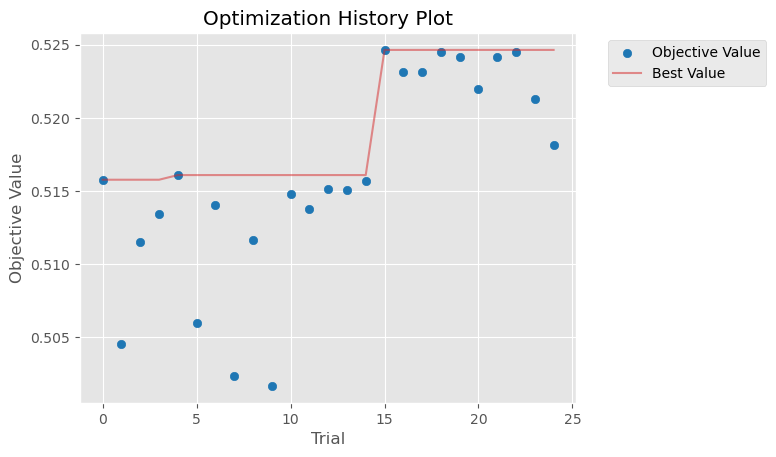

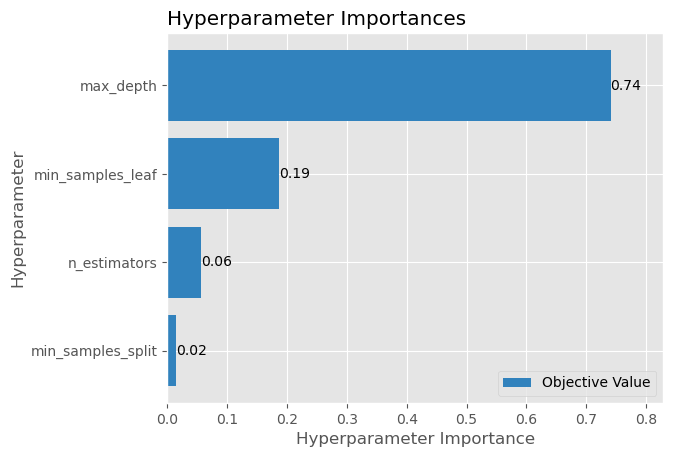

In [212]:
print("Number of finished trials: {}".format(len(study_brf.trials)))

print("Best trial:")
trial = study_brf.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

plot_optimization_history(study_brf)
plot_param_importances(study_brf)

In [213]:
brf_tuned_optuna = BalancedRandomForestClassifier(**study_brf.best_trial.params)
brf_tuned_optuna.fit(X_train, y_train)

brf_tuned_op_pred = brf_tuned_optuna.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=brf_tuned_op_pred)

Accuracy: 0.7866824046562741

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.81      0.86     20125
           1       0.44      0.66      0.53      4444

    accuracy                           0.79     24569
   macro avg       0.68      0.74      0.70     24569
weighted avg       0.83      0.79      0.80     24569



In [214]:
add_to_tuning_eval_df(
    model=brf_tuned_optuna,
    model_name="BalancedRandomForestClassifier",
    tuning="optuna",
    scorer="f1",
    best_params=study_brf.best_trial.params,
    x_data_train=X_train,
    y_data_train=y_train,
    x_data_test=X_test,
    y_data_test=y_test)

##### Modell 2: CatBoostClassifier

###### Reference Model

In [174]:
cat_base_smote = CatBoostClassifier()
cat_base_smote.fit(X_smote, y_smote)

Learning rate set to 0.071708
0:	learn: 0.6774960	total: 103ms	remaining: 1m 42s
1:	learn: 0.6639870	total: 205ms	remaining: 1m 42s
2:	learn: 0.6523973	total: 305ms	remaining: 1m 41s
3:	learn: 0.6426335	total: 405ms	remaining: 1m 40s
4:	learn: 0.6349124	total: 511ms	remaining: 1m 41s
5:	learn: 0.6275646	total: 612ms	remaining: 1m 41s
6:	learn: 0.6215961	total: 709ms	remaining: 1m 40s
7:	learn: 0.6155216	total: 805ms	remaining: 1m 39s
8:	learn: 0.6110747	total: 903ms	remaining: 1m 39s
9:	learn: 0.6068535	total: 1s	remaining: 1m 39s
10:	learn: 0.6019818	total: 1.1s	remaining: 1m 38s
11:	learn: 0.5985429	total: 1.2s	remaining: 1m 38s
12:	learn: 0.5948518	total: 1.29s	remaining: 1m 38s
13:	learn: 0.5907423	total: 1.39s	remaining: 1m 37s
14:	learn: 0.5868151	total: 1.49s	remaining: 1m 37s
15:	learn: 0.5832702	total: 1.59s	remaining: 1m 37s
16:	learn: 0.5805555	total: 1.69s	remaining: 1m 37s
17:	learn: 0.5774033	total: 1.79s	remaining: 1m 37s
18:	learn: 0.5739192	total: 1.88s	remaining: 1m 3

In [175]:
cat_smote_base_pred = cat_base_smote.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=cat_smote_base_pred)

Accuracy: 0.8367047905897675

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     20125
           1       0.55      0.53      0.54      4444

    accuracy                           0.84     24569
   macro avg       0.72      0.72      0.72     24569
weighted avg       0.83      0.84      0.84     24569



In [176]:
add_to_tuning_eval_df(
    model=cat_base_smote,
    model_name="CatBoostClassifier",
    tuning="none",
    scorer="none",
    best_params="",
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1a: RandomizedSearchCV

In [177]:
param_grid_cat1 = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1],
    'border_count': [32, 50, 100],
    'scale_pos_weight': [1, 2, 3],
    'random_seed': [42]
}

In [178]:
rs_cat1 = RandomizedSearchCV(CatBoostClassifier(verbose=False),
                             param_grid_cat1,
                             scoring='f1',
                             n_jobs=-1,
                             verbose=1,
                             n_iter=10)
rs_cat1.fit(X_smote, y_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fc424713f50>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 0.5, 1],
                                        'border_count': [32, 50, 100],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [100, 200, 500],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'random_seed': [42],
                                        'scale_pos_weight': [1, 2, 3]},
                   scoring='f1', verbose=1)

In [179]:
cat_tuned1 = CatBoostClassifier(**rs_cat1.best_params_, verbose=False)
cat_tuned1.fit(X_smote, y_smote)

In [180]:
cat_tuned1_pred = cat_tuned1.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=cat_tuned1_pred)

Accuracy: 0.7829378485082827

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.80      0.86     20125
           1       0.44      0.68      0.53      4444

    accuracy                           0.78     24569
   macro avg       0.68      0.74      0.70     24569
weighted avg       0.83      0.78      0.80     24569



In [181]:
add_to_tuning_eval_df(
    model=cat_tuned1,
    model_name="CatBoostClassifier",
    tuning="RandomizedSearchCV",
    scorer="f1",
    best_params=rs_cat1.best_params_,
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1b: RandomizedSearchCV + custom scorer (target)

In [182]:
param_grid_cat2 = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1],
    'border_count': [32, 50, 100],
    'scale_pos_weight': [1, 2, 3],
    'random_seed': [42]
}

In [183]:
rs_cat2 = RandomizedSearchCV(CatBoostClassifier(verbose=False),
                             param_grid_cat2,
                             scoring=custom_scorer_target,
                             n_jobs=-1,
                             verbose=1,
                             n_iter=10)
rs_cat2.fit(X_smote, y_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fc52c23d490>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 0.5, 1],
                                        'border_count': [32, 50, 100],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [100, 200, 500],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'random_seed': [42],
                                        'scale_pos_weight': [1, 2, 3]},
                   scoring=make_scorer(custom_f1_target_score, response_method='predict'),
                   verbose=1)

In [184]:
cat_tuned2 = CatBoostClassifier(**rs_cat2.best_params_, verbose=False)
cat_tuned2.fit(X_smote, y_smote)

In [185]:
cat_tuned2_pred = cat_tuned2.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=cat_tuned2_pred)

Accuracy: 0.7919329236029142

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     20125
           1       0.45      0.67      0.54      4444

    accuracy                           0.79     24569
   macro avg       0.68      0.75      0.70     24569
weighted avg       0.83      0.79      0.81     24569



In [186]:
add_to_tuning_eval_df(
    model=cat_tuned2,
    model_name="CatBoostClassifier",
    tuning="RandomizedSearchCV",
    scorer="target",
    best_params=rs_cat2.best_params_,
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1c: RandomizedSearchCV + custom scorer (macro f1)

In [187]:
param_grid_cat3 = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1],
    'border_count': [32, 50, 100],
    'scale_pos_weight': [1, 2, 3],
    'random_seed': [42]
}

In [188]:
rs_cat3 = RandomizedSearchCV(CatBoostClassifier(verbose=False),
                             param_grid_cat3,
                             scoring=custom_scorer_macro,
                             n_jobs=-1,
                             verbose=1,
                             n_iter=10)
rs_cat3.fit(X_smote, y_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fc424742110>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 0.5, 1],
                                        'border_count': [32, 50, 100],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [100, 200, 500],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'random_seed': [42],
                                        'scale_pos_weight': [1, 2, 3]},
                   scoring=make_scorer(custom_f1_macro_score, response_method='predict'),
                   verbose=1)

In [189]:
cat_tuned3 = CatBoostClassifier(**rs_cat3.best_params_, verbose=False)
cat_tuned3.fit(X_smote, y_smote)

In [190]:
cat_tuned3_pred = cat_tuned3.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=cat_tuned3_pred)

Accuracy: 0.8332451463226016

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     20125
           1       0.54      0.53      0.53      4444

    accuracy                           0.83     24569
   macro avg       0.72      0.71      0.72     24569
weighted avg       0.83      0.83      0.83     24569



In [191]:
add_to_tuning_eval_df(
    model=cat_tuned3,
    model_name="CatBoostClassifier",
    tuning="RandomizedSearchCV",
    scorer="f1-macro",
    best_params=rs_cat3.best_params_,
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#1d: RandomizedSearchCV + custom scorer (mcc)

In [192]:
param_grid_cat4 = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1],
    'border_count': [32, 50, 100],
    'scale_pos_weight': [1, 2, 3],
    'random_seed': [42]
}

In [193]:
rs_cat4 = RandomizedSearchCV(CatBoostClassifier(verbose=False),
                             param_grid_cat4,
                             scoring=custom_scorer_mcc,
                             n_jobs=-1,
                             verbose=1,
                             n_iter=10)
rs_cat4.fit(X_smote, y_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fc42474e050>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 0.5, 1],
                                        'border_count': [32, 50, 100],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [100, 200, 500],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'random_seed': [42],
                                        'scale_pos_weight': [1, 2, 3]},
                   scoring=make_scorer(mcc, response_method='predict'),
                   verbose=1)

In [194]:
cat_tuned4 = CatBoostClassifier(**rs_cat4.best_params_, verbose=False)
cat_tuned4.fit(X_smote, y_smote)

In [195]:
cat_tuned4_pred = cat_tuned4.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=cat_tuned4_pred)

Accuracy: 0.8086206194798323

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88     20125
           1       0.48      0.64      0.55      4444

    accuracy                           0.81     24569
   macro avg       0.70      0.74      0.71     24569
weighted avg       0.83      0.81      0.82     24569



In [196]:
add_to_tuning_eval_df(
    model=cat_tuned4,
    model_name="CatBoostClassifier",
    tuning="RandomizedSearchCV",
    scorer="mcc",
    best_params=rs_cat4.best_params_,
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_test=X_test,
    y_data_test=y_test)

###### Tuning#2: optuna

In [215]:
n_trials = 25

In [216]:
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_uniform('random_strength', 1.0, 10.0),
        'early_stopping_rounds': 50,
        'eval_metric': 'F1'
    }

    model = CatBoostClassifier(random_state=42, **params, verbose=False)

    cv_score = cross_val_score(model, X_smote, y_smote, n_jobs=-1, cv=5, scoring='f1')
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

In [217]:
sampler = TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study_cat = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")
study_cat.optimize(objective_cat, n_trials=n_trials)

[I 2025-02-16 09:31:22,332] A new study created in memory with name: no-name-e9f10d20-a2bf-486f-9398-fb91428c740b
[I 2025-02-16 09:45:09,159] Trial 0 finished with value: 0.8721160286768835 and parameters: {'iterations': 437, 'learning_rate': 0.566984951147885, 'depth': 9, 'l2_leaf_reg': 0.039079671568228794, 'border_count': 66, 'bagging_temperature': 0.15599452033620265, 'random_strength': 1.5227525095137953}. Best is trial 0 with value: 0.8721160286768835.
[I 2025-02-16 10:06:50,621] Trial 1 finished with value: 0.779065026673534 and parameters: {'iterations': 880, 'learning_rate': 0.010129197956845729, 'depth': 8, 'l2_leaf_reg': 1.3289448722869181e-05, 'border_count': 249, 'bagging_temperature': 0.8324426408004217, 'random_strength': 2.9110519961044856}. Best is trial 0 with value: 0.8721160286768835.
[I 2025-02-16 10:08:16,748] Trial 2 finished with value: 0.4552758929384907 and parameters: {'iterations': 263, 'learning_rate': 8.260808399079601e-05, 'depth': 6, 'l2_leaf_reg': 0.014

KeyboardInterrupt: 

Number of finished trials: 14
Best trial:
  Value: 0.5246440174672629
  Params: 
    iterations: 437
    learning_rate: 0.566984951147885
    depth: 9
    l2_leaf_reg: 0.039079671568228794
    border_count: 66
    bagging_temperature: 0.15599452033620265
    random_strength: 1.5227525095137953


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

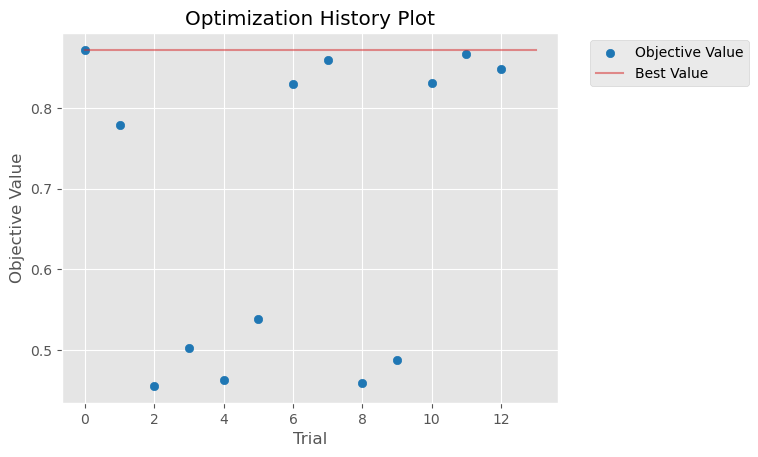

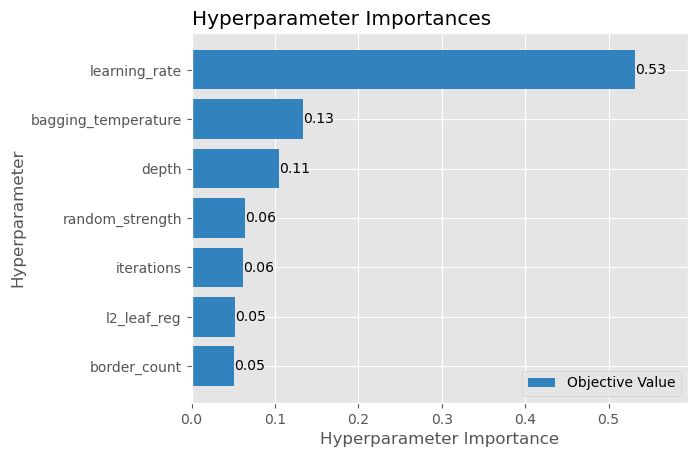

In [218]:
print("Number of finished trials: {}".format(len(study_cat.trials)))

print("Best trial:")
trial_cat = study_cat.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial_cat.params.items():
    print("    {}: {}".format(key, value))

plot_optimization_history(study_cat)
plot_param_importances(study_cat)

In [220]:
cat_tuned_optuna = CatBoostClassifier(**study_cat.best_trial.params, verbose=False)
cat_tuned_optuna.fit(X_train, y_train)

cat_tuned_op_pred = cat_tuned_optuna.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=cat_tuned_op_pred)

Accuracy: 0.8360942651308559

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90     20125
           1       0.57      0.40      0.47      4444

    accuracy                           0.84     24569
   macro avg       0.72      0.67      0.69     24569
weighted avg       0.82      0.84      0.82     24569



In [221]:
add_to_tuning_eval_df(
    model=cat_tuned_optuna,
    model_name="CatBoostClassifier",
    tuning="optuna",
    scorer="f1",
    best_params=study_cat.best_trial.params,
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_test=X_test,
    y_data_test=y_test)

#### Modellvergleich (ohne VotingClassifier)

In [242]:
evaluation_tuning.sort_values(by=["test_f1"], ascending=False).head()

,model,tuning,scorer,best_params,train_acc,train_prec,train_rec,train_f1,train_mcc,test_acc,test_prec,test_rec,test_f1,test_mcc,clf_rep_train,clf_rep_test
0,BalancedRandomForestClassifier,none,none,,0.935057,0.734522,0.999903,0.846910,0.822372,0.805120,0.471813,0.647840,0.545989,0.434475,precision recall f1-score ...,precision recall f1-score ...
10,CatBoostClassifier,RandomizedSearchCV,mcc,"{'scale_pos_weight': 2, 'random_seed': 42, 'le...",0.926756,0.896638,0.964723,0.929436,0.855984,0.808621,0.478173,0.635914,0.545876,0.434679,precision recall f1-score ...,precision recall f1-score ...
5,BalancedRandomForestClassifier,RandomizedSearchCV,mcc,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.882220,0.606459,0.980969,0.749536,0.711560,0.787619,0.444010,0.690594,0.540507,0.427710,precision recall f1-score ...,precision recall f1-score ...
6,CatBoostClassifier,none,none,,0.891309,0.915697,0.861976,0.888025,0.783969,0.836705,0.550657,0.528353,0.539274,0.440231,precision recall f1-score ...,precision recall f1-score ...
8,CatBoostClassifier,RandomizedSearchCV,target,"{'scale_pos_weight': 2, 'random_seed': 42, 'le...",0.884835,0.849167,0.935911,0.890431,0.773717,0.791933,0.449759,0.672817,0.539127,0.425458,precision recall f1-score ...,precision recall f1-score ...


In [245]:
evaluation_tuning[evaluation_tuning.model == "BalancedRandomForestClassifier"].sort_values(by=["test_f1"], ascending=False).head()

,model,tuning,scorer,best_params,train_acc,train_prec,train_rec,train_f1,train_mcc,test_acc,test_prec,test_rec,test_f1,test_mcc,clf_rep_train,clf_rep_test
0,BalancedRandomForestClassifier,none,none,,0.935057,0.734522,0.999903,0.846910,0.822372,0.805120,0.471813,0.647840,0.545989,0.434475,precision recall f1-score ...,precision recall f1-score ...
5,BalancedRandomForestClassifier,RandomizedSearchCV,mcc,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.882220,0.606459,0.980969,0.749536,0.711560,0.787619,0.444010,0.690594,0.540507,0.427710,precision recall f1-score ...,precision recall f1-score ...
11,BalancedRandomForestClassifier,optuna,f1,"{'n_estimators': 200, 'max_depth': 85, 'min_sa...",0.856106,0.569416,0.816390,0.670896,0.598011,0.786682,0.440584,0.664941,0.529997,0.413441,precision recall f1-score ...,precision recall f1-score ...
4,BalancedRandomForestClassifier,RandomizedSearchCV,f1-macro,"{'n_estimators': 50, 'min_samples_split': 2, '...",0.821847,0.502757,0.761239,0.605569,0.514475,0.777525,0.424941,0.650990,0.514220,0.392564,precision recall f1-score ...,precision recall f1-score ...
2,BalancedRandomForestClassifier,RandomizedSearchCV,f1,"{'n_estimators': 200, 'min_samples_split': 10,...",0.774434,0.421713,0.688319,0.523000,0.406136,0.770239,0.415363,0.663141,0.510789,0.388174,precision recall f1-score ...,precision recall f1-score ...


In [244]:
evaluation_tuning[evaluation_tuning.model == "CatBoostClassifier"].sort_values(by=["test_f1"], ascending=False).head()

,model,tuning,scorer,best_params,train_acc,train_prec,train_rec,train_f1,train_mcc,test_acc,test_prec,test_rec,test_f1,test_mcc,clf_rep_train,clf_rep_test
10,CatBoostClassifier,RandomizedSearchCV,mcc,"{'scale_pos_weight': 2, 'random_seed': 42, 'le...",0.926756,0.896638,0.964723,0.929436,0.855984,0.808621,0.478173,0.635914,0.545876,0.434679,precision recall f1-score ...,precision recall f1-score ...
6,CatBoostClassifier,none,none,,0.891309,0.915697,0.861976,0.888025,0.783969,0.836705,0.550657,0.528353,0.539274,0.440231,precision recall f1-score ...,precision recall f1-score ...
8,CatBoostClassifier,RandomizedSearchCV,target,"{'scale_pos_weight': 2, 'random_seed': 42, 'le...",0.884835,0.849167,0.935911,0.890431,0.773717,0.791933,0.449759,0.672817,0.539127,0.425458,precision recall f1-score ...,precision recall f1-score ...
9,CatBoostClassifier,RandomizedSearchCV,f1-macro,"{'scale_pos_weight': 1, 'random_seed': 42, 'le...",0.864655,0.898018,0.822744,0.858734,0.731886,0.833245,0.540042,0.526553,0.533212,0.431774,precision recall f1-score ...,precision recall f1-score ...
7,CatBoostClassifier,RandomizedSearchCV,f1,"{'scale_pos_weight': 2, 'random_seed': 42, 'le...",0.869259,0.831916,0.925512,0.876222,0.743236,0.782938,0.436144,0.683168,0.532398,0.416971,precision recall f1-score ...,precision recall f1-score ...


##### Ergebnis
- bei BRF gar keine Verbesserung durch Tuning
- bei CBC konnte der Recall auf Kosten der Precision gesteigert werden, gleichzeitig minimale Verbesserung von F1, dabei aber minimaler Verlust MCC

##### Modell 3: VotingClassifier

###### Basismodell VotingClassifier

In [255]:
add_to_tuning_eval_df(
    model=vote_base_smote,
    model_name="VotingClassifier",
    tuning="",
    scorer="",
    best_params="LR, RF, LinearSVC",
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_test=X_test,
    y_data_test=y_test)

###### VotingClassifier: bester BalancedRandomForest + Base-LinearSVC + LR

In [256]:
base_models_vote_smote1 = [
    ('lr', LogisticRegression(random_state=42)), ('brf', BalancedRandomForestClassifier(random_state=42)),
    ('svc', LinearSVC(random_state=42))
]

In [257]:
vote_base_smote1 = VotingClassifier(estimators=base_models_vote_smote1, voting='hard', n_jobs=-1)
vote_base_smote1.fit(X_smote, y_smote)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('brf',
                              BalancedRandomForestClassifier(random_state=42)),
                             ('svc', LinearSVC(random_state=42))],
                 n_jobs=-1)

In [258]:
add_to_tuning_eval_df(
    model=stack_base1,
    model_name="VotingClassifier",
    tuning="",
    scorer="",
    best_params="LR, BRF, LinearSVC",
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_test=X_test,
    y_data_test=y_test)

###### VotingClassifier: bester CatBoostClassifier + Base-LinearSVC + LR

In [232]:
print(rs_cat4.best_params_)

{'scale_pos_weight': 2, 'random_seed': 42, 'learning_rate': 0.2, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 10, 'border_count': 100, 'bagging_temperature': 0}


In [261]:
base_models_vote_smote2 = [
    ('lr', LogisticRegression(random_state=42)), ('cat', CatBoostClassifier(scale_pos_weight=2, random_seed=42, learning_rate=0.2, l2_leaf_reg=3, iterations=500, depth=10, border_count=100, bagging_temperature=0)),
    ('svc', LinearSVC(random_state=42))
]

In [262]:
vote_base_smote2 = VotingClassifier(estimators=base_models_vote_smote2, voting='hard', n_jobs=-1)
vote_base_smote2.fit(X_smote, y_smote)

0:	learn: 0.6226640	total: 689ms	remaining: 5m 43s
1:	learn: 0.5898586	total: 1.3s	remaining: 5m 23s
2:	learn: 0.5669349	total: 1.91s	remaining: 5m 16s
3:	learn: 0.5511711	total: 2.51s	remaining: 5m 11s
4:	learn: 0.5375983	total: 3.13s	remaining: 5m 9s
5:	learn: 0.5241820	total: 3.74s	remaining: 5m 8s
6:	learn: 0.5054104	total: 4.35s	remaining: 5m 6s
7:	learn: 0.4969592	total: 4.95s	remaining: 5m 4s
8:	learn: 0.4898004	total: 5.57s	remaining: 5m 3s
9:	learn: 0.4826373	total: 6.18s	remaining: 5m 2s
10:	learn: 0.4765806	total: 6.79s	remaining: 5m 1s
11:	learn: 0.4713269	total: 7.41s	remaining: 5m 1s
12:	learn: 0.4675676	total: 8.02s	remaining: 5m
13:	learn: 0.4606341	total: 8.63s	remaining: 4m 59s
14:	learn: 0.4568836	total: 9.25s	remaining: 4m 59s
15:	learn: 0.4537022	total: 9.87s	remaining: 4m 58s
16:	learn: 0.4505517	total: 10.5s	remaining: 4m 58s
17:	learn: 0.4464508	total: 11.1s	remaining: 4m 57s
18:	learn: 0.4419869	total: 11.7s	remaining: 4m 57s
19:	learn: 0.4385877	total: 12.4s	r

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7fc382b96650>),
                             ('svc', LinearSVC(random_state=42))],
                 n_jobs=-1)

In [264]:
add_to_tuning_eval_df(
    model=vote_base_smote2,
    model_name="VotingClassifier",
    tuning="",
    scorer="",
    best_params="LR, CBC, LinearSVC",
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_test=X_test,
    y_data_test=y_test)

462:	learn: 0.2117412	total: 4m 52s	remaining: 23.3s
463:	learn: 0.2115580	total: 4m 52s	remaining: 22.7s
464:	learn: 0.2113182	total: 4m 53s	remaining: 22.1s
465:	learn: 0.2111740	total: 4m 54s	remaining: 21.5s
466:	learn: 0.2110583	total: 4m 54s	remaining: 20.8s
467:	learn: 0.2109953	total: 4m 55s	remaining: 20.2s
468:	learn: 0.2107778	total: 4m 56s	remaining: 19.6s
469:	learn: 0.2107323	total: 4m 56s	remaining: 18.9s
470:	learn: 0.2106592	total: 4m 57s	remaining: 18.3s
471:	learn: 0.2103780	total: 4m 58s	remaining: 17.7s
472:	learn: 0.2103369	total: 4m 58s	remaining: 17.1s
473:	learn: 0.2102921	total: 4m 59s	remaining: 16.4s
474:	learn: 0.2100367	total: 5m	remaining: 15.8s
475:	learn: 0.2099139	total: 5m	remaining: 15.2s
476:	learn: 0.2096184	total: 5m 1s	remaining: 14.5s
477:	learn: 0.2094906	total: 5m 2s	remaining: 13.9s
478:	learn: 0.2092973	total: 5m 2s	remaining: 13.3s
479:	learn: 0.2092540	total: 5m 3s	remaining: 12.6s
480:	learn: 0.2091842	total: 5m 4s	remaining: 12s
481:	lea

#### Modellvergleich (mit VotingClassifier)

In [265]:
evaluation_tuning.sort_values(by=["test_f1"], ascending=False).head(10)

,model,tuning,scorer,best_params,train_acc,train_prec,train_rec,train_f1,train_mcc,test_acc,test_prec,test_rec,test_f1,test_mcc,clf_rep_train,clf_rep_test
0,BalancedRandomForestClassifier,none,none,,0.935057,0.734522,0.999903,0.846910,0.822372,0.805120,0.471813,0.647840,0.545989,0.434475,precision recall f1-score ...,precision recall f1-score ...
10,CatBoostClassifier,RandomizedSearchCV,mcc,"{'scale_pos_weight': 2, 'random_seed': 42, 'le...",0.926756,0.896638,0.964723,0.929436,0.855984,0.808621,0.478173,0.635914,0.545876,0.434679,precision recall f1-score ...,precision recall f1-score ...
5,BalancedRandomForestClassifier,RandomizedSearchCV,mcc,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.882220,0.606459,0.980969,0.749536,0.711560,0.787619,0.444010,0.690594,0.540507,0.427710,precision recall f1-score ...,precision recall f1-score ...
6,CatBoostClassifier,none,none,,0.891309,0.915697,0.861976,0.888025,0.783969,0.836705,0.550657,0.528353,0.539274,0.440231,precision recall f1-score ...,precision recall f1-score ...
15,VotingClassifier,,,"LR, CBC, LinearSVC",0.888311,0.871327,0.911181,0.890808,0.777436,0.803207,0.467681,0.636589,0.539217,0.425830,precision recall f1-score ...,precision recall f1-score ...
8,CatBoostClassifier,RandomizedSearchCV,target,"{'scale_pos_weight': 2, 'random_seed': 42, 'le...",0.884835,0.849167,0.935911,0.890431,0.773717,0.791933,0.449759,0.672817,0.539127,0.425458,precision recall f1-score ...,precision recall f1-score ...
13,VotingClassifier,,,"LR, RF, LinearSVC",0.902696,0.888153,0.921430,0.904486,0.805958,0.807847,0.476026,0.618812,0.538108,0.425144,precision recall f1-score ...,precision recall f1-score ...
9,CatBoostClassifier,RandomizedSearchCV,f1-macro,"{'scale_pos_weight': 1, 'random_seed': 42, 'le...",0.864655,0.898018,0.822744,0.858734,0.731886,0.833245,0.540042,0.526553,0.533212,0.431774,precision recall f1-score ...,precision recall f1-score ...
7,CatBoostClassifier,RandomizedSearchCV,f1,"{'scale_pos_weight': 2, 'random_seed': 42, 'le...",0.869259,0.831916,0.925512,0.876222,0.743236,0.782938,0.436144,0.683168,0.532398,0.416971,precision recall f1-score ...,precision recall f1-score ...
11,BalancedRandomForestClassifier,optuna,f1,"{'n_estimators': 200, 'max_depth': 85, 'min_sa...",0.856106,0.569416,0.816390,0.670896,0.598011,0.786682,0.440584,0.664941,0.529997,0.413441,precision recall f1-score ...,precision recall f1-score ...


##### Ergebnis
- minimale Verbesserung des VotingClassifiers durch Verwendung des CBC mit Tuning 

####  Test auf finalen Testdaten

#### Top 2 Models (tuned)

In [266]:
df_test = pd.read_csv("../../../data/mixed_dataset/test_cleaned.csv", index_col=0)
df_test = df_test[df_test.tweet_cleaned.notna()]
df_train.head()

,Unnamed: 0,label,tweet_cleaned
0,140232,0,"nickis "" good pout buy botox trade mark mkr"
1,6083,0,great game ever fun possible
2,62913,0,love enjoy tran
3,13525,0,yes good eurotrash
4,6318,0,wait euro sta friday euro


In [267]:
X_test_final = df_test["tweet_cleaned"]
y_test_final = df_test["label"]

In [268]:
X_test_final = tfidf_vectorizer.transform(X_test_final)

##### Model evaluation

##### Top-Model#1: CatBoostClassifier

In [14]:
best_tuned_cat = CatBoostClassifier(scale_pos_weight=2, random_seed=42, learning_rate=0.2, l2_leaf_reg=3, iterations=500, depth=10, border_count=100, bagging_temperature=0, verbose=False)
best_tuned_cat.fit(X_smote, y_smote)

In [15]:
best_tuned_cat_pred = best_tuned_cat.predict(X_test)
simple_evaluation(y_test=y_test, y_pred=best_tuned_cat_pred)

NameError: name 'simple_evaluation' is not defined

In [280]:
add_to_final_eval_df(
    model=best_tuned_cat,
    model_name="CatBoostClassifier",
    tuning="RandomizedSearchCV",
    best_params=rs_cat4.best_params_,
    scorer="target",
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_val=X_test,
    y_data_val=y_test,
    x_data_test=X_test_final,
    y_data_test=y_test_final,
    thresh=0.5)

##### Top-Model#2: BalancedRandomForestClassifier

In [11]:
best_tuned_brf = BalancedRandomForestClassifier()
best_tuned_brf.fit(X_train, y_train)

BalancedRandomForestClassifier()

In [281]:
add_to_final_eval_df(
    model=best_tuned_brf,
    model_name="BalancedRandomForestClassifier",
    tuning="none",
    best_params="",
    scorer="none",
    x_data_train=X_train,
    y_data_train=y_train,
    x_data_val=X_test,
    y_data_val=y_test,
    x_data_test=X_test_final,
    y_data_test=y_test_final,
    thresh=0.5)

##### Schwellwert ändern

In [282]:
new_threshold = 0.35

In [283]:
add_to_final_eval_df(
    model=best_tuned_cat,
    model_name="CatBoostClassifier",
    tuning="RandomizedSearchCV",
    best_params=rs_cat2.best_params_,
    scorer="target",
    x_data_train=X_smote,
    y_data_train=y_smote,
    x_data_val=X_test,
    y_data_val=y_test,
    x_data_test=X_test_final,
    y_data_test=y_test_final,
    thresh=new_threshold)

In [284]:
add_to_final_eval_df(
    model=best_tuned_brf,
    model_name="BalancedRandomForestClassifier",
    tuning="none",
    best_params="",
    scorer="none",
    x_data_train=X_train,
    y_data_train=y_train,
    x_data_val=X_test,
    y_data_val=y_test,
    x_data_test=X_test_final,
    y_data_test=y_test_final,
    thresh=new_threshold)

In [285]:
final_evaluation_tuning.sort_values(by=["test_f1"], ascending=False)

,model,tuning,scorer,thresh,train_acc,train_prec,train_rec,train_f1,train_mcc,val_acc,...,val_mcc,test_acc,test_prec,test_rec,test_f1,test_mcc,clf_rep_train,clf_rep_val,clf_rep_test,best_params
1,BalancedRandomForestClassifier,none,none,0.50,0.932807,0.727825,0.999903,0.842441,0.817394,0.798893,...,0.427286,0.764354,0.564768,0.749856,0.644282,0.483909,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,
0,CatBoostClassifier,RandomizedSearchCV,target,0.50,0.926756,0.896638,0.964723,0.929436,0.855984,0.808621,...,0.434679,0.770575,0.579108,0.709520,0.637715,0.477571,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,"{'scale_pos_weight': 2, 'random_seed': 42, 'le..."
2,CatBoostClassifier,RandomizedSearchCV,target,0.35,0.882772,0.815177,0.990006,0.894125,0.783782,0.739875,...,0.402053,0.693370,0.477922,0.838151,0.608737,0.427691,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,"{'scale_pos_weight': 2, 'random_seed': 42, 'le..."
3,BalancedRandomForestClassifier,none,none,0.35,0.815288,0.493058,1.000000,0.660468,0.618093,0.711547,...,0.393895,0.666216,0.455086,0.875683,0.598918,0.415724,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,


##### Ergebnisse speichern

In [287]:
final_evaluation_tuning.to_csv("evaluation/final_evaluation_best_tuned_models.csv")

#### Modelle speichern

In [12]:
joblib.dump(tfidf_vectorizer, "evaluation/tfidf_vectorizer.joblib")

['evaluation/tfidf_vectorizer.joblib']

In [13]:
joblib.dump(best_tuned_brf, "evaluation/tfidf_balancedrandomforest.joblib")

['evaluation/tfidf_balancedrandomforest.joblib']

In [ ]:
joblib.dump(best_tuned_cat, "evaluation/tfidf_catboostclassifier.joblib")